In [1]:
import tensorflow_quantum as tfq
import tensorflow as tf
import cirq
import sympy
import random
import matplotlib.pyplot as plt
import numpy as np
import csv
import datetime
import time

from DataSet import DataSet
from Circuit import Circuit
from qat.interop.cirq import qlm_to_cirq

2024-05-10 19:29:05.904502: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-05-10 19:29:05.904584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-05-10 19:29:09.339037: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2024-05-10 19:29:09.339125: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2024-05-10 19:29:09.339191: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (arturo-virtual-machine): /proc/driver/nvidia/version does not exist
2024-05-10 19:29:09.339599: I tensorflow/core/platform

In [2]:
def make_data_aux(X_values):
    qubit = cirq.LineQubit.range(2)
    train = []
    
    for values in X_values:
        cir = cirq.Circuit()
        for value in values:
            z = sympy.symbols('Y_rot')
            cir.append(cirq.H(qubit[0]))
            cir.append(cirq.H(qubit[1]))
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.rz(z).on(qubit[1]) ** 2 ** (np.pi - value) ** (np.pi - value))
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.H(qubit[0]))
            cir.append(cirq.H(qubit[1]))
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.rz(z).on(qubit[0]) ** value ** 2)
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
            cir.append(cirq.rz(z).on(qubit[1]) ** 2 ** (np.pi - value) ** (np.pi - value))
            cir.append(cirq.CNOT(qubit[0], qubit[1]))
        train.append(cir)
    return tfq.convert_to_tensor(train)

def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


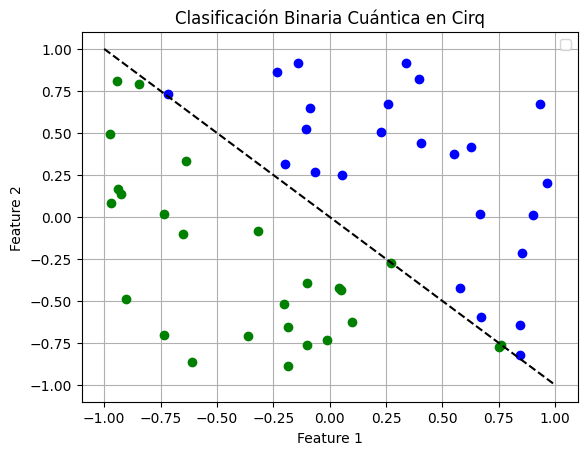

In [3]:
dataset = DataSet(seed=40)
dataset.Draw()

In [ ]:
score_list = []

with open('datos_entrenamiento_circuito3_50samples.csv', mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Fecha', 'Hora', 'Tiempo de ejecucion(s)', 'Fidelidad', 'Libreria'])

    for i in range(100):
        start = time.time()
        circuit = Circuit()
        circuit.varCircuit3()
        cirq_circuit = qlm_to_cirq(circuit.circuit())
        
        no_measurements_circuit = cirq.drop_terminal_measurements(cirq_circuit)
        
        train = make_data_aux(dataset.X_aux)
        
        qubit = cirq.LineQubit.range(2)
        readout_operators = [cirq.X(qubit[0])]
        inputs = tf.keras.Input(shape=(), dtype=tf.dtypes.string)
        
        layer1 = tfq.layers.PQC(cirq_circuit, readout_operators, repetitions=32, differentiator=tfq.differentiators.ParameterShift(), initializer=tf.keras.initializers.Zeros)(inputs)
        model = tf.keras.models.Model(inputs=inputs, outputs=layer1)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.001), loss=tf.keras.losses.hinge, metrics=[hinge_accuracy])
        
        history = model.fit(train, dataset.y, epochs=1, batch_size=32)
        acc = history.history['hinge_accuracy']
        end = time.time()
        tiempo_ejecucion = end - start

        now = datetime.datetime.now()
        fecha = now.strftime("%Y-%m-%d")
        hora = now.strftime("%H:%M:%S")
        libreria = 'Cirq - Tensor flow quantum'

        writer.writerow([fecha, hora, tiempo_ejecucion, acc, libreria])
        score_list.append(acc)

/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 483ms/step - loss: 0.9925 - hinge_accuracy: 0.6215


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 653ms/step - loss: 0.9937 - hinge_accuracy: 0.6302


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 547ms/step - loss: 1.0287 - hinge_accuracy: 0.5312


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 489ms/step - loss: 1.0225 - hinge_accuracy: 0.5590


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 599ms/step - loss: 0.9937 - hinge_accuracy: 0.5417


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 625ms/step - loss: 0.9850 - hinge_accuracy: 0.6493


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 595ms/step - loss: 0.9950 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 796ms/step - loss: 0.9962 - hinge_accuracy: 0.5382


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 663ms/step - loss: 1.0338 - hinge_accuracy: 0.5035


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 492ms/step - loss: 1.0338 - hinge_accuracy: 0.5191


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 609ms/step - loss: 1.0087 - hinge_accuracy: 0.5903


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 608ms/step - loss: 0.9700 - hinge_accuracy: 0.6719


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 581ms/step - loss: 0.9962 - hinge_accuracy: 0.6181


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 537ms/step - loss: 0.9850 - hinge_accuracy: 0.6493


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 564ms/step - loss: 1.0113 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 556ms/step - loss: 1.0013 - hinge_accuracy: 0.6337


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 583ms/step - loss: 1.0100 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 515ms/step - loss: 1.0113 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 511ms/step - loss: 0.9925 - hinge_accuracy: 0.6024


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 668ms/step - loss: 0.9750 - hinge_accuracy: 0.7205


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 466ms/step - loss: 0.9887 - hinge_accuracy: 0.5816


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 571ms/step - loss: 0.9950 - hinge_accuracy: 0.5660


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 547ms/step - loss: 0.9850 - hinge_accuracy: 0.5417


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 457ms/step - loss: 1.0100 - hinge_accuracy: 0.5312


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 543ms/step - loss: 1.0050 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 520ms/step - loss: 1.0000 - hinge_accuracy: 0.5868


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 476ms/step - loss: 0.9862 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 660ms/step - loss: 1.0063 - hinge_accuracy: 0.5503


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 514ms/step - loss: 1.0050 - hinge_accuracy: 0.5712


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 704ms/step - loss: 1.0037 - hinge_accuracy: 0.5903


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 662ms/step - loss: 1.0163 - hinge_accuracy: 0.5868


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 531ms/step - loss: 1.0037 - hinge_accuracy: 0.5868


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 560ms/step - loss: 0.9875 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 452ms/step - loss: 1.0025 - hinge_accuracy: 0.5816


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 588ms/step - loss: 1.0013 - hinge_accuracy: 0.6094


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 546ms/step - loss: 0.9925 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 506ms/step - loss: 0.9750 - hinge_accuracy: 0.6962


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 522ms/step - loss: 0.9950 - hinge_accuracy: 0.5938


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 563ms/step - loss: 1.0075 - hinge_accuracy: 0.6024


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 464ms/step - loss: 1.0063 - hinge_accuracy: 0.5903


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 961ms/step - loss: 1.0187 - hinge_accuracy: 0.5590


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 6s 1s/step - loss: 1.0150 - hinge_accuracy: 0.4913


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 948ms/step - loss: 0.9837 - hinge_accuracy: 0.5851


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 6s 1s/step - loss: 0.9825 - hinge_accuracy: 0.6493


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 5s 944ms/step - loss: 0.9875 - hinge_accuracy: 0.6528


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 5s 1s/step - loss: 1.0000 - hinge_accuracy: 0.6302


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 882ms/step - loss: 0.9900 - hinge_accuracy: 0.6215


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 849ms/step - loss: 0.9962 - hinge_accuracy: 0.6146


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 824ms/step - loss: 0.9762 - hinge_accuracy: 0.6771


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 790ms/step - loss: 0.9912 - hinge_accuracy: 0.5816


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 461ms/step - loss: 1.0013 - hinge_accuracy: 0.6181


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 4s 879ms/step - loss: 1.0075 - hinge_accuracy: 0.5191


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 515ms/step - loss: 0.9975 - hinge_accuracy: 0.5781


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 459ms/step - loss: 0.9962 - hinge_accuracy: 0.5660


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 487ms/step - loss: 0.9900 - hinge_accuracy: 0.6094


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 501ms/step - loss: 0.9975 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 440ms/step - loss: 0.9925 - hinge_accuracy: 0.5747


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 455ms/step - loss: 1.0037 - hinge_accuracy: 0.6059


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 515ms/step - loss: 0.9787 - hinge_accuracy: 0.5538


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 554ms/step - loss: 0.9800 - hinge_accuracy: 0.5972


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 536ms/step - loss: 1.0075 - hinge_accuracy: 0.5069


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 453ms/step - loss: 1.0025 - hinge_accuracy: 0.6024


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 521ms/step - loss: 1.0163 - hinge_accuracy: 0.5069


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 497ms/step - loss: 1.0400 - hinge_accuracy: 0.5243


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 526ms/step - loss: 1.0087 - hinge_accuracy: 0.5503


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 486ms/step - loss: 0.9862 - hinge_accuracy: 0.5573


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 517ms/step - loss: 1.0237 - hinge_accuracy: 0.5191


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 613ms/step - loss: 1.0175 - hinge_accuracy: 0.5069


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 471ms/step - loss: 1.0050 - hinge_accuracy: 0.5312


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 540ms/step - loss: 0.9962 - hinge_accuracy: 0.5660


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 481ms/step - loss: 1.0037 - hinge_accuracy: 0.5660


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 526ms/step - loss: 1.0050 - hinge_accuracy: 0.5903


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 587ms/step - loss: 0.9987 - hinge_accuracy: 0.5816


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 539ms/step - loss: 1.0275 - hinge_accuracy: 0.5955


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 510ms/step - loss: 0.9862 - hinge_accuracy: 0.5851


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 474ms/step - loss: 1.0050 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 469ms/step - loss: 0.9800 - hinge_accuracy: 0.5816


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 595ms/step - loss: 1.0163 - hinge_accuracy: 0.5226


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 436ms/step - loss: 1.0125 - hinge_accuracy: 0.5347


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 475ms/step - loss: 0.9887 - hinge_accuracy: 0.5781


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 465ms/step - loss: 1.0037 - hinge_accuracy: 0.5938


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 543ms/step - loss: 0.9975 - hinge_accuracy: 0.5104


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 517ms/step - loss: 0.9887 - hinge_accuracy: 0.5781


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 566ms/step - loss: 0.9962 - hinge_accuracy: 0.5503


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 545ms/step - loss: 1.0013 - hinge_accuracy: 0.5781


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 477ms/step - loss: 0.9975 - hinge_accuracy: 0.5191


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 488ms/step - loss: 1.0113 - hinge_accuracy: 0.6146


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 456ms/step - loss: 0.9950 - hinge_accuracy: 0.5660


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 592ms/step - loss: 0.9925 - hinge_accuracy: 0.6858


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 583ms/step - loss: 1.0000 - hinge_accuracy: 0.5781


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 507ms/step - loss: 1.0113 - hinge_accuracy: 0.5347


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 399ms/step - loss: 1.0137 - hinge_accuracy: 0.5347


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 434ms/step - loss: 0.9600 - hinge_accuracy: 0.6806


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 3s 585ms/step - loss: 0.9900 - hinge_accuracy: 0.5625


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 510ms/step - loss: 1.0213 - hinge_accuracy: 0.4757


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 489ms/step - loss: 1.0200 - hinge_accuracy: 0.5191


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 553ms/step - loss: 1.0237 - hinge_accuracy: 0.5156


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


2/2 [==============================] - 2s 460ms/step - loss: 1.0063 - hinge_accuracy: 0.6146


/home/arturo/miniconda3/envs/tf/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
print(score_list)